In [8]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")


In [9]:
from langchain_groq import ChatGroq

In [10]:
import wikipediaapi
import wikipedia
from serpapi import GoogleSearch

In [11]:
llm = ChatGroq(model="Gemma2-9b-It", temperature=0.2)

In [12]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState

In [13]:
sys_msg1 = SystemMessage (content = "You are a helpful assistant tasked with generating blog title, pick the first catchy title.")
sys_msg2 = SystemMessage (content = "You are writing the blog using {query}. Use the following search results {combined_result} for generation. \
                          You will generate the following 3 sections. \
                          1. introduction (50 words stating the core problem) \
                          2. main body containing technical details and problem solution within 300 words. \
                          3. Conclusion (50 words, summarizing the key messages. Make it concise and impactful). \
                          Ensure to mention clear section titles and bullet points. ")
sys_msg3 = SystemMessage (content = "You are an Editor tasked with reviewing blog title and mainbody. \
                          If everything looks good provide approved as feedback. \
                          If title needs to be revised provide revise_title as feedback \
                          If main body needs to be revised provide revise_body as feedback. ")

In [14]:
wiki_obj = wikipediaapi.Wikipedia(user_agent= "MyAIApp/1.0 (ravibhattinkw@gmail.com)",language="en")
def clean_query(query):
        
        ignore_words = ["Generate a blog on", "Write about", "What is", "Who is", "Explain"]
    
        for word in ignore_words:
            query = query.replace(word, "").strip()

        return query  # Return cleaned-up query for better Wikipedia search

def fetch_wiki_data(query):

    query = clean_query(query)

    get_wiki_page = wikipedia.search(query)

    #print("Get Wiki Page:",get_wiki_page)

    #best_match = wiki_obj.page (get_wiki_page[1]) # Fetch from wikipedia
    for match in get_wiki_page:
        try:
            return wikipedia.summary(match, sentences=3)  # Limit to 3 sentences
        except wikipedia.exceptions.PageError:
            continue  # Try next title if PageError occurs
        except wikipedia.exceptions.DisambiguationError as e:
            return f"Multiple results found: {e.options[:5]}..."  # Show first 5 options
    
    #if best_match.exists():
    #    return wikipedia.summary(best_match, sentences=5)
    #else:
    #    "No Wikipedia data found"

#print(fetch_wiki_data("Generate a blog on Greatness of Novak Djokovic?"))

In [16]:
def fetch_google_search_results(query):
    # Search Google with serper API
    params = {
        "engine": "google",
        "q": query,
        #"api_key": os.environ["SERPER_API_KEY"
    }

    search = GoogleSearch(params)
    results = search.get_dict()
    #print("🔍 Raw API Response:", results)

    top3_search = [result["snippet"] for result in results.get("organic_results", [])[:3]]  # Get top 3 snippets
    return " ".join(top3_search) if top3_search else "No relevant search results found."

In [17]:
import re

def title_generator(state: MessagesState):
    title = llm.invoke([sys_msg1] + state["messages"])  # No config needed
    return {"messages": state["messages"] + [title]}

def mainbody_generator(state: MessagesState):
    title_msg = state["messages"][-1]  

    query = state["messages"][0].content

    #print("query:",query)

    wiki_info = fetch_wiki_data(query)

    #print("Wiki_info",wiki_info)
    
    google_search_info = fetch_google_search_results(query)

    combined_result = f"Wikipedia Result: {wiki_info} \n  Google Search Result: {google_search_info}"

    #print("combined_result:", combined_result)
    updated_sys_msg2 = SystemMessage( content=sys_msg2.content.format(query=query, combined_result=combined_result))
    
    main_body = llm.invoke([updated_sys_msg2, title_msg])  
    return {"messages": state["messages"] + [main_body]}

def editor(state: MessagesState):
    aggregated_message = "\n\n".join([msg.content for msg in state["messages"]])

    editor_feedback = llm.invoke( [sys_msg3, HumanMessage(content=aggregated_message)])
    match = re.search(r"\b(approved|revise_title|revise_body)\b", editor_feedback.content.lower())

    feedback = match.group(1) 

    valid_feedback = ["approved", "revise_title", "revise_body"]
    if feedback not in valid_feedback:
        raise ValueError(f" Unexpected feedback from LLM: {feedback}")

    return {"editor_feedback": feedback}
    
    
    

#def conclusion_generator(state: MessagesState):
#    relevant_messages = state["messages"][-2:]  
#    conclusion = llm.invoke([sys_msg3] + relevant_messages)  
#    return {"messages": state["messages"] + [conclusion]}

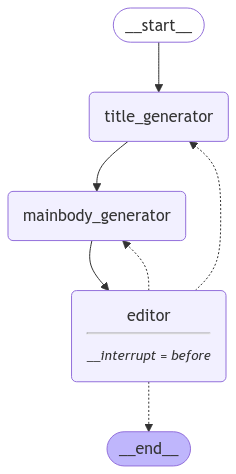

================================ Human Message =================================

Generate a blog on Greatness of Novak Djokovic
================================== Ai Message ==================================

##  Djokovic: The Maestro of the Court - A Legacy Forged in Grit and Grace 


Let's dive into a blog post celebrating the greatness of Novak Djokovic:

**Djokovic: The Maestro of the Court - A Legacy Forged in Grit and Grace**

Novak Djokovic. The name itself evokes images of relentless returns, impossible angles, and a steely determination that has redefined what it means to be a tennis champion.  His dominance on the court is undeniable, his trophy cabinet overflowing with Grand Slam titles and records that seem destined to stand the test of time. But beyond the statistics and accolades, Djokovic's greatness transcends the realm of sport. He embodies a unique blend of grit and grace, a warrior spirit tempered by an unwavering respect for the game and his opponents.

This blog 

In [22]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(MessagesState)

builder.add_node( "title_generator", title_generator)
builder.add_node( "mainbody_generator", mainbody_generator)
builder.add_node( "editor", editor)

builder.add_edge ( START, "title_generator" )
builder.add_edge ( "title_generator", "mainbody_generator" )
builder.add_edge ( "mainbody_generator", "editor")

def editor_decision(state):
    """Conditional routing based on the editor's feedback."""
    feedback = state["editor_feedback"]  # Assuming editor gives structured feedback
    
    if feedback == "approved":
        return END
    elif feedback == "revise_title":
        return "title_generator"
    elif feedback == "revise_body":
        return "mainbody_generator"
    else:
        raise ValueError("Invalid editor feedback")

builder.add_conditional_edges ( "editor",
                               #if the output of mainbody_generator needs review route flow to mainbody or Title generator
                               #if the output of mainbody_generator is good route to END 
                               editor_decision)

memory = MemorySaver()
react_graph = builder.compile(interrupt_before=["editor"], checkpointer=memory)

#react_graph = builder.compile()

display (Image(react_graph.get_graph().draw_mermaid_png()))

#messages = [HumanMessage(content = "Generate a blog on Good AI Governance")]
#messages = react_graph.invoke({ "messages": messages})

#for m in messages['messages']:
    #m.pretty_print()

messages = {"messages":HumanMessage(content = "Generate a blog on Greatness of Novak Djokovic")}
thread={"configurable":{"thread_id":"1"}}
#interrupted_state = react_graph.invoke({ "messages": messages})
for event in react_graph.stream(messages,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()


#for m in messages['messages']:
#    m.pretty_print()



In [19]:
from ipywidgets import widgets
from IPython.display import display
import IPython
from langgraph.checkpoint.memory import MemorySaver


# ✅ Compile LangGraph with a checkpoint namespace
#react_graph = builder.compile(interrupt_before=["editor"], checkpointer=memory)

# ✅ Prepare Input Message
messages = {"messages": [HumanMessage(content="Generate a blog on Greatness of Novak Djokovic")]}

# ✅ Required Thread Configuration
thread_config = {"configurable": {"thread_id": "1"}}

# 🚀 First Invocation (Stream Until "editor", Then Pause)
print("\n🚀 **Generating Blog Content...**")
for event in react_graph.stream(messages, thread_config, stream_mode="values"):
    IPython.display.display(event["messages"][-1].content)  # ✅ Displaying output in Notebook

# 🚀 Human Reviews Content & Provides Feedback
print("\n🔍 **Editor Review Required** 🔍\n")
for msg in event["messages"]:
    IPython.display.display(msg.content)  # ✅ Displaying in Jupyter

# ✅ Create a dropdown for editor feedback
feedback_widget = widgets.Dropdown(
    options=["approved", "revise_title", "revise_body"],
    description="Feedback:",
    disabled=False
)
display(feedback_widget)

# ✅ Wait for human input (Jupyter workaround)
def on_submit(change):
    global human_feedback
    human_feedback = change.new
    print(f"\n✅ Selected Feedback: {human_feedback}")

feedback_widget.observe(on_submit, names="value")



🚀 **Generating Blog Content...**


'Generate a blog on Greatness of Novak Djokovic'

"##  Novak Djokovic: The Relentless Pursuit of Perfection \n\nNovak Djokovic. The name alone sends shivers down the spines of his opponents and sparks awe in the hearts of tennis fans worldwide.  He's not just a player; he's a phenomenon, a force of nature who has redefined what it means to be a champion.  \n\nDjokovic's greatness isn't just about the record-breaking 24 Grand Slam titles, though those are certainly impressive. It's about the relentless pursuit of perfection, the unwavering focus, and the sheer mental fortitude that has seen him conquer every surface and overcome every obstacle.\n\n**A Master of All Surfaces:**\n\nFrom the clay courts of Roland Garros to the hallowed grass of Wimbledon and the hard courts of the US Open, Djokovic has proven his mastery on every surface imaginable.  His adaptability is unmatched, his game evolving and refining with each passing year.  He's a chameleon on the court, seamlessly shifting his style to exploit his opponent's weaknesses and do

''


🔍 **Editor Review Required** 🔍



'Generate a blog on Greatness of Novak Djokovic'

"##  Djokovic: The Maestro of the Court - A Legacy Forged in Grit and Grace \n\n\nLet's dive into a blog post celebrating Novak Djokovic's greatness:\n\n**Djokovic: The Maestro of the Court - A Legacy Forged in Grit and Grace**\n\nNovak Djokovic. The name itself evokes images of unwavering focus, relentless determination, and breathtaking athleticism.  He stands as a titan in the world of tennis, a player whose dominance has redefined the sport and etched his name in the annals of history. \n\nBut Djokovic's greatness transcends mere statistics.  It's a tapestry woven from grit, grace, and an unwavering pursuit of perfection. \n\n**The Unstoppable Force:**\n\nDjokovic's trophy cabinet is a testament to his unparalleled success.  With a record-breaking 24 Grand Slam singles titles, he has surpassed even the legendary Roger Federer and Rafael Nadal.  His mastery of all surfaces – clay, grass, and hard court – is a testament to his versatility and adaptability. \n\n**Beyond the Numbers:**

''

'Generate a blog on Greatness of Novak Djokovic'

"##  Novak Djokovic: The Relentless Pursuit of Perfection \n\nNovak Djokovic. The name alone sends shivers down the spines of his opponents and sparks awe in the hearts of tennis fans worldwide.  He's not just a player; he's a phenomenon, a force of nature who has redefined what it means to be a champion.  \n\nDjokovic's greatness isn't just about the record-breaking 24 Grand Slam titles, though those are certainly impressive. It's about the relentless pursuit of perfection, the unwavering focus, and the sheer mental fortitude that has seen him conquer every surface and overcome every obstacle.\n\n**A Master of All Surfaces:**\n\nFrom the clay courts of Roland Garros to the hallowed grass of Wimbledon and the hard courts of the US Open, Djokovic has proven his mastery on every surface imaginable.  His adaptability is unmatched, his game evolving and refining with each passing year.  He's a chameleon on the court, seamlessly shifting his style to exploit his opponent's weaknesses and do

''

Dropdown(description='Feedback:', options=('approved', 'revise_title', 'revise_body'), value='approved')


✅ Selected Feedback: revise_title
